## 결정 트리 모델의 시각화(Decision Tree Visualization)

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)
# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(random_state=156)

In [ ]:
iris_data.target_names
iris_data.feature_names

In [33]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(dt_clf, out_file='tree.dot', class_names= iris_data.target_names,\
                feature_names=iris_data.feature_names, impurity=True, filled=True)
# impurity(불순도): 지니계수 출력
# filled : 최종 분류된 노드를 구분하기 위해 색칠

### 결정트리 시각화 및 지니계수 계산

루트 노드 지니계수 계산 : 0.667
4번째 노드 지니계수 계산 : 0.051


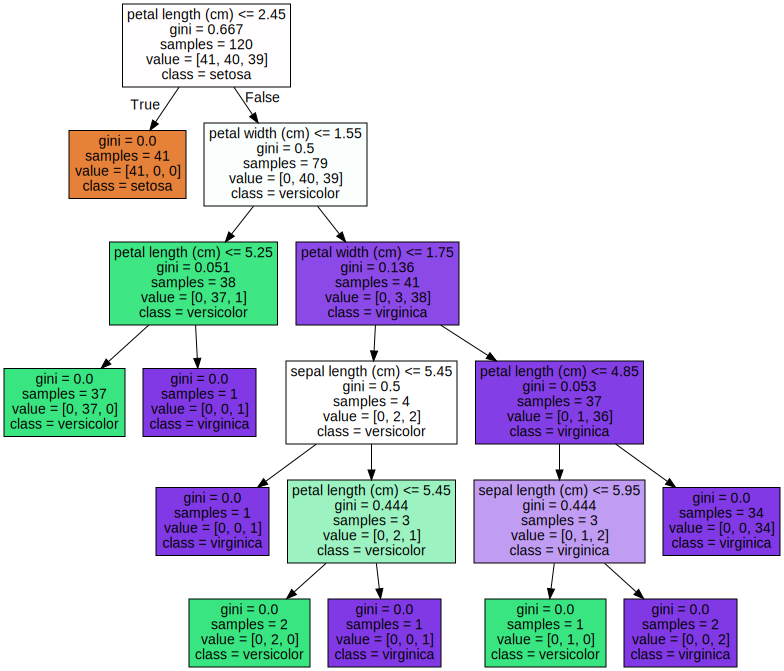

In [65]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
print(f"루트 노드 지니계수 계산 : {round(1 - (41/120)**2 - (40/120)**2 - (39/120)**2,3)}")
print(f"4번째 노드 지니계수 계산 : {round(1 - (0/38)**2 - (37/38)**2 - (1/37)**2,3)}")
# 출처 : https://yganalyst.github.io/ml/ML_chap5/
graphviz.Source(dot_graph)

In [35]:
iris_data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### min_samples_split과 min_samples_leaf 차이
**min_samples_split는 분할 할 수 있는 최소 샘플수를 지정하는 것이고, min_samples_leaf를 분할해서 leaf가 될 수 있는 샘플수를 지정하는 것**<br>
예를들어, min_samples_split = 6 개이고, min_samples_leaf가 4개인데,<br>
6개의 sample로 Node에 개별 클래스 값이 각각 3개씩 들어가 있으면<br>
min_samples_leaf의 최소 갯수가 4개이기 때문에 leaf node로 만들수 없어서 분할하지 못합니다.

## feature_importance_

Feature importances: [0.025, 0.0, 0.555, 0.42]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


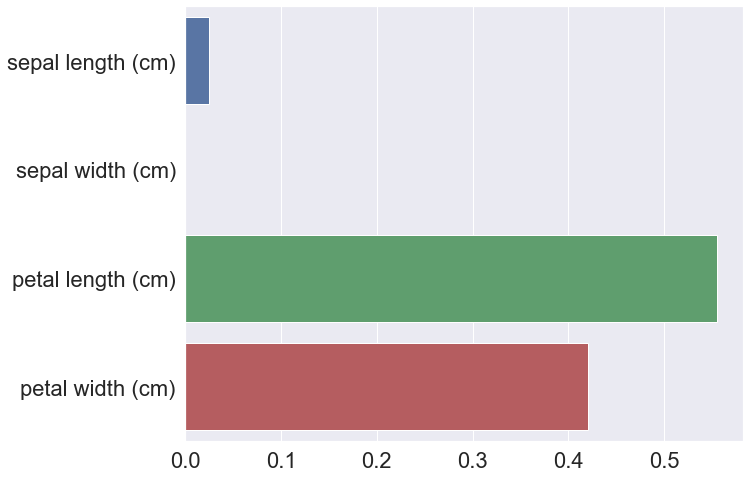

In [49]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# feature importance 추출 
print(f"Feature importances: {list(np.round(dt_clf.feature_importances_,3))}")

# feature별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print(f"{name} : {value:.3f}")

# feature importance를 column 별로 시각화 하기
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)
plt.show()

### Feature importance 계산 원리

사이킷런의 feature importance는 **각 feature별로 개별 노드의 Gini importance를 합산하여 계수화 한 것**입니다.

feature별 Gini importance는 각 feature들이 사용된 트리 노드에서의 **지니계수와 해당 노드의 가중치가 부여된 데이터 건수**를 곱한 값을 구한 뒤,<br>
이 노드의 자식 노드인 **왼쪽과 오른쪽 노드 각각의 지니계수와 가중치 부여한 데이터 건수를 곱한것을 마이너스** 하여 계산합니다.  

아래는 이를 Pseudo 코드로 만든 것입니다.

해당 자료는 https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3 를 참조하였고, Pseudo 코드는 사이킷런의 tree 소스 코드를 참조하였습니다. 

```python
#해당노드가 마지막 노드가 아닐동안 루프 수행.
while node != end_node:
    # 만일 해당 노드가 리프노드가 아니면 해당 노드의 왼쪽 자식, 오른쪽 자식 노드를 구함
    if node.left_child != _TREE_LEAF:
        # ... and node.right_child != _TREE_LEAF:
        left = &nodes[node.left_child]
        right = &nodes[node.right_child]
       
        '''해당 노드가 특정 feature가 사용되었을 경우 지니계수(여기서는 impurity)와 해당 노드의 가중치가 부여된 데이터
        건수를 곱한 값에서 왼쪽과 오른쪽 노드 각각의 지니계수와 가중치 부여 데이터 건수를 곱한것을 마이너스한 값들을 해당
        feature가  소속된 모든 노드에서 합산 적용 '''
        importance_data[node.feature] += (
            node.weighted_n_node_samples * node.impurity -
            left.weighted_n_node_samples * left.impurity -
            right.weighted_n_node_samples * right.impurity)
   

    #다음 노드로 이동.
    node += 1

# 루드 노드의 가중치 부여 데이터 건수로 나눔.
importance_data /= nodes[0].weighted_n_node_samples
```

## 결정 트리(Decision TREE) 과적합(Overfitting)

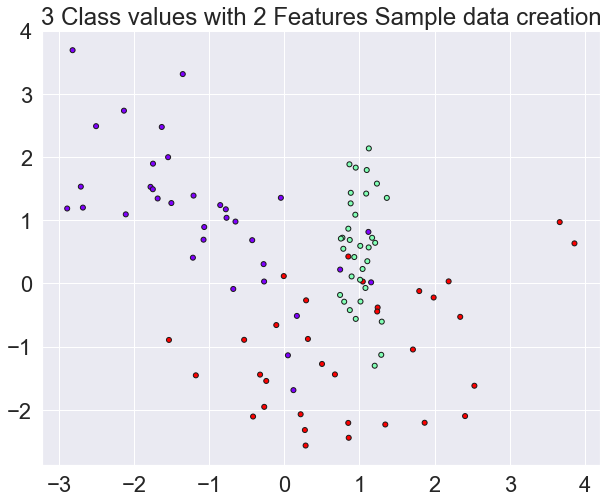

In [59]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.title("3 Class values with 2 Features Sample data creation")

# 2차원 시각화를 위해서 feature는 2개, 결정값 클래스는 3가지 유형의 테스트 샘플 데이터 생성
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                          n_classes=3, n_clusters_per_class=1, random_state=0)
# plot 형태로 2개의 feature로 2차원 좌표 시각화, 각 클래스값은 다른 색깔로 표시됨.
# X_feature[:,0]이 X축, X_features[:,1]이 y축, c=컬러 종류에 따른 샘플 리스트 (0,1,2 3가지로 구성)
plt.scatter(X_features[:,0], X_features[:,1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolors='k')
plt.show()

In [64]:
print(f"X_features 3개\n{X_features[:3]}")
print(f"y_labels 10개: {y_labels[:10]}")

X_features 3개
[[ 0.12041909 -1.68941375]
 [ 1.09665605  1.79445113]
 [ 0.88426577  1.43370121]]
y_labels 10개: [0 1 1 1 2 2 1 0 2 2]


In [73]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    # X의 shape는 (N,2) -->.    X[:,0] : 첫번째 열,     X[:,1]: 두번째 열
    # c : markers color
    # s : markers size
    # cmap : ColorMap
    # clim : set color limits
    # zorder : 겹치는 경우 레이어 개수
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

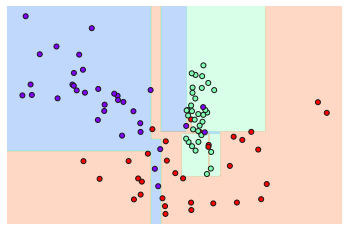

In [85]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 Decsion Boundary 시각화.
dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels) # X_features는 특징 2개 -> 특징1개는 x축, 1개는 y축

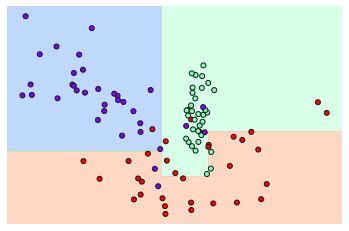

In [86]:
# min_samples_leaf=6 으로 트리 생성 조건을 제약한 Decision Boundary 시각화
dt_clf = DecisionTreeClassifier(random_state=156, min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

<img src="https://blog.kakaocdn.net/dn/d71RGX/btrBtBLkrmK/wO0qahRqNHBVRXOK1IL710/img.png" width="1400">

    왼쪽 그림은 학습 데이터에 과적합된 모습이다. 학습 데이터에 대해서는 정확도가 높을 수 있지만,
    test 데이터는 좀 더 유연하게 들어오기 때문에 제대로 예측을 못할 가능성이 높다.
    반면에 오른쪽처럼 좀 유연성을 갖고 예측을 하는게 테스트 데이터에 대해 더 높은 예측을 할 가능성이 높다.

## 결정 트리 실습 - Human Activity Recognition

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
# header=None 안하면, 첫번째 행이 컬럼이름이 된다.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+', #\s+는 공백 정규식 -> 공백 구분자로 df생성
                        header=None,names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.column_name.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


### **중복된 피처명을 확인**

In [108]:
# column_name으로 group_by해서 count()
feature_dup_df = feature_name_df.groupby('column_name').count()
feature_dup_df.head(3)

,column_index
column_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1


In [109]:
feature_dup_df2 = feature_dup_df[feature_dup_df.column_index > 1]
print(f"피처중 중복된 피처들의 개수는 {feature_dup_df2.shape[0]}개")
feature_dup_df2.head(4)

피처중 중복된 피처들의 개수는 42개


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3


**원본 데이터에 중복된 Feature 명으로 인하여 신규 버전의 Pandas에서 Duplicate name 에러를 발생.**  
**중복 feature명에 대해서 원본 feature 명에 '_1(또는2)'를 추가로 부여하는 함수인 get_new_feature_name_df() 생성**

In [115]:
feature_dup_df = pd.DataFrame(data=feature_name_df.groupby('column_name').cumcount(),
                             columns=['dup_cnt'])
print(feature_dup_df.value_counts())

dup_cnt
0          477
1           42
2           42
dtype: int64


In [119]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0],  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [120]:
# cumcount 로직 설명 : 서로 같은 인자끼리 개수를 따로셈
df = pd.DataFrame([['a'], ['a'], ['a'], ['b'], ['b'], ['a']], columns=['A'])
display(df)
df.groupby('A').cumcount()

,A
0,a
1,a
2,a
3,b
4,b
5,a


0    0
1    1
2    2
3    0
4    1
5    3
dtype: int64

### 중복된 피처 cumcount 처리

In [28]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [121]:
# 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                    header=None,names=['column_index','column_name'])

# 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
new_feature_name_df = get_new_feature_name_df(feature_name_df)

# DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
## 여기까지가 feature_name을 얻기위한 과정
feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)

# 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

In [147]:
feature_name[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [135]:
print(f'## 학습 피처 데이터셋 info()\n')
X_train.info()

## 학습 피처 데이터셋 info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [136]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


### 결정트리 학습/예측/정확도

In [142]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


### **GridSearchCV**: 최적 하이퍼 파라미터

In [159]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split': [16]
}

dt_clf = DecisionTreeClassifier()
g_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1, refit=1)
# 학습 데이터 학습
g_cv.fit(X_train, y_train)
# 최고 평균 정확도: best_score_
print(f"GridSearchCV 최고 평균 정확도: {g_cv.best_score_:.2%}")
# 최적 하이퍼 파라미터: best_params_
print(f"GridSearchCV 최적 하이퍼 파라미터: {g_cv.best_params_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도: 84.98%
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_split': 16}


In [160]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(g_cv.cv_results_)
# max_depth 파라미터 값과 그때의 테스트(Evaluation), 학습 셋의 정확도 수치 추출
# max_depth에 따른 성능 확인 가능
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847934
1,8,0.848757
2,10,0.849846
3,12,0.842775
4,16,0.843589
5,20,0.848895
6,24,0.841550


In [163]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 셋 예측/ 정확도 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"max_depth = {depth}의 정확도: {acc:.2%}")
# 위에서 하이퍼파라미터 확인한 대로, 테스트셋에 대해서도 max_depth 8에서 정확도가 가장 높음을 알 수 있다.

max_depth = 6의 정확도: 85.51%
max_depth = 8의 정확도: 87.17%
max_depth = 10의 정확도: 85.99%
max_depth = 12의 정확도: 85.71%
max_depth = 16의 정확도: 85.99%
max_depth = 20의 정확도: 85.65%
max_depth = 24의 정확도: 85.65%


In [168]:
params = {
    'max_depth' : [ 8, 12], 
    'min_samples_split' : [16],
}

dt_clf = DecisionTreeClassifier()
g_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
g_cv.fit(X_train, y_train)
# refit=1에 의해 최고성능을 학습한 에스티메이터를 g_cv가 가지고 있다.
best_dt_clf = g_cv.best_estimator_
pred_b = best_dt_clf.predict(X_test)
acc_b = accuracy_score(y_test, pred_b)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [171]:
print(f"최고 Estimator: {best_dt_clf}")
print(f"최고 예측 정확도: {acc_b:2%}")

최고 Estimator: DecisionTreeClassifier(max_depth=8, min_samples_split=16)
최고 예측 정확도: 87.410926%


### Feature_importance 보기

In [182]:
ftr_impt_values = best_dt_clf.feature_importances_
print(f"X_train.columns 3개만: {X_train.columns[:3]}")
ftr_impts = pd.Series(ftr_impt_values, index=X_train.columns)
# 상위 5개만
ftr_impts.sort_values(ascending=False)[:5]

X_train.columns 3개만: Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z'], dtype='object')


tGravityAcc-min()-X                0.253354
fBodyAccJerk-bandsEnergy()-1,24    0.214038
angle(Y,gravityMean)               0.139001
fBodyAccMag-energy()               0.115478
tGravityAcc-arCoeff()-Z,2          0.101548
dtype: float64

ftr_tp20 index 3개 : ['tGravityAcc-min()-X', 'fBodyAccJerk-bandsEnergy()-1,24', 'angle(Y,gravityMean)']
ftr_tp20.values 3개 : [0.2533544  0.21403833 0.1390006 ]


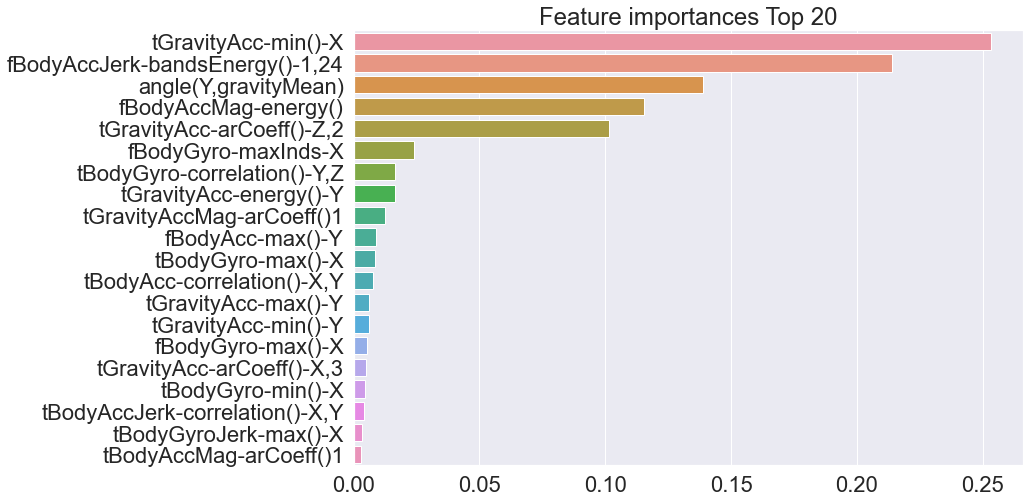

In [195]:
import seaborn as sns
# 중요도값 순으로 20개만 저장
ftr_tp20 = ftr_impts.sort_values(ascending=False)[:20]
print(f"ftr_tp20 index 3개 : {ftr_tp20.index[:3].tolist()}")
print(f"ftr_tp20.values 3개 : {ftr_tp20.values[:3]}")

plt.figure(figsize=(12,8))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_tp20.values, y = ftr_tp20.index)
plt.show()